Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.
The data set contains the following diseases:

Actinic keratosis
Basal cell carcinoma
Dermatofibroma
Melanoma
Nevus
Pigmented benign keratosis
Seborrheic keratosis
Squamous cell carcinoma
Vascular lesion

Importing Skin Cancer Data

In [1]:
#importing all necessary libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Defining the path for train and test imagesDesktop/test/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train
data_dir_train = pathlib.Path("C:/Users/arpit/Desktop/test/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('C:/Users/arpit/Desktop/test/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

Create a dataset
Define some parameters for the loader:

Use 80% of the images for training, and 20% for validation.

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False
)
     

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Visualize the data
Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [8]:

### your code goes here, you can use training or validation data to visualize
# Function to generate image map
def generate_image_map(image_ds,batch_num=1):
  # Dictionary to store one image per label (0 to 9)
  label_image_map = {}
  # Iterate through the dataset without limiting the number of batches
  for images, labels in image_ds.skip(batch_num-1).take(batch_num):
      # Loop through each image and its corresponding label
      for image, label in zip(images.numpy(), labels.numpy()):
          # If we haven't already stored an image for this label
          if label not in label_image_map:
              label_image_map[label] = image  # Store the image with the unique label
          # Stop once we have one image for each label (0 to 9)
          if len(label_image_map) == 10:
              break  # Exit the inner loop if all 10 labels are found
      if len(label_image_map) == 10:
          break  # Exit outer loop once all labels are covered
  # Sort the dictionary by keys
  sorted_image_map=dict(sorted(label_image_map.items()))
  # Display the keys of the dictionary to check which labels have been collected
  print("Labels found:", sorted_image_map.keys())
  return sorted_image_map


# Function to plot sample images
def plot_sample_images(class_names, label_image_map):
  plt.figure(figsize=(20, 10))
  for idx, (label, image) in enumerate(label_image_map.items()):
      plt.subplot(2, 5, idx + 1)  # Create a 2x5 grid for the images
      plt.imshow(image.astype("uint8"))  # Display the image
      plt.title(f"Class: {class_names[label]}")  # Display the class name
      plt.axis('off')  # Turn off the axis
  # Show the plot with all images
  plt.tight_layout()
  plt.show()

In [9]:

# Genarate random batch number between 0 and 10
import random
batch_num=random.randint(1,11)
batch_num

2

Labels found: dict_keys([0, 1, 3, 4, 5, 6, 7, 8])


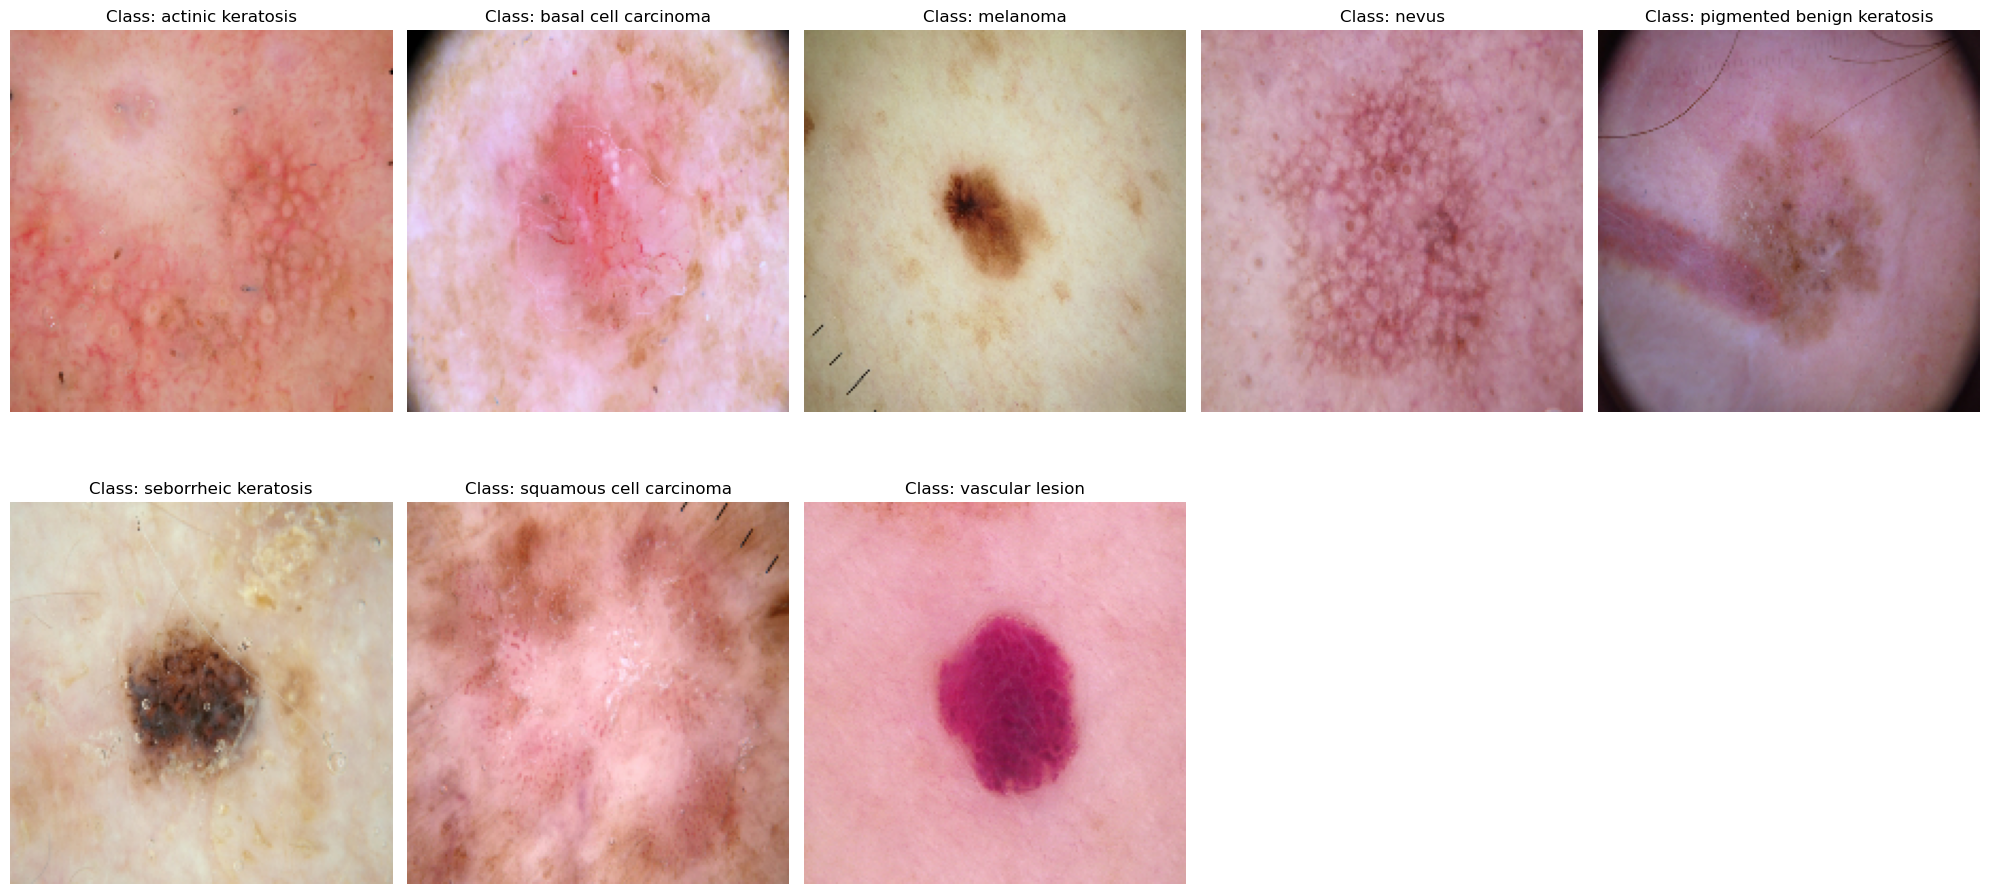

In [10]:

# Visualize Train Data
train_image_map=generate_image_map(train_ds,batch_num)
plot_sample_images(class_names,train_image_map)

Labels found: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])


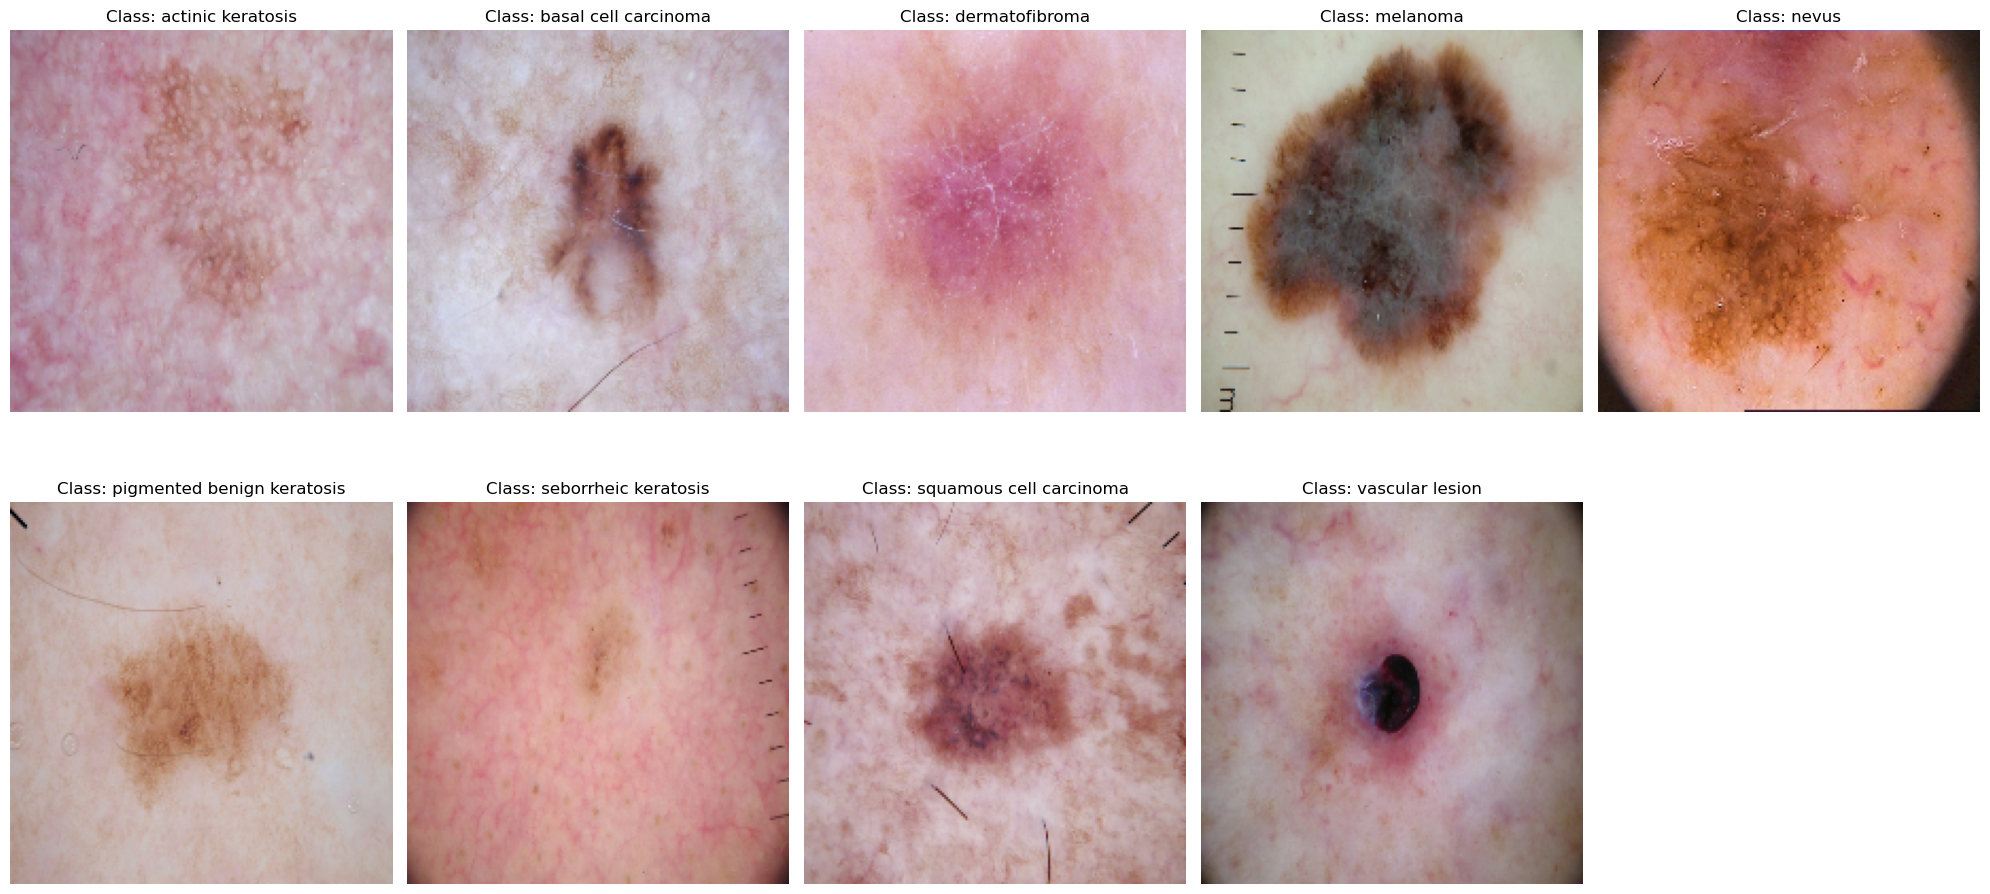

In [11]:

# Visualize Validation Data
val_image_map=generate_image_map(val_ds,batch_num)
plot_sample_images(class_names,val_image_map)

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model
Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [13]:


model=Sequential(name="Melanoma_Detection_Model")
# Adding Rescaling layer
model.add(layers.Rescaling(1.0/255.0 , offset=0.0 , input_shape=(img_height,img_width,3), name="Rescaling_Layer"))
# First Part
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu",  name="Conv2D_Layer_1"))  # adding first Convolution layer
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1")) # adding first Max Pooling layer
# Second Part
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_2")) # adding second Convolution layer
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2")) # adding second Max Pooling layer
# Flattening the output
model.add(layers.Flatten(name="Flatten_Layer"))
# Fully Connected Layer
model.add(layers.Dense(units=128,activation="relu",name="FC_Layer_1") )# adding first fully connected layer
model.add(layers.Dropout(0.20,name="Dropout_1")) # adding dropouts
# Output Layer
model.add(layers.Dense(units=len(class_names),activation="softmax",name="Output_Layer")) # adding output layer

C:\Users\arpit\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:

### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_Layer_1 (Conv2D)         │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_Layer_1            │ (None, 90, 90, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_Layer_2 (Conv2D)         │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_Layer_2            │ (None, 45, 45, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ (None, 129600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC_Layer_1 (Dense)              │ (None, 128)            │    16,588,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,609,481 (63.36 MB)

 Trainable params: 16,609,481 (63.36 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.2672 - loss: 2.5386 - val_accuracy: 0.4161 - val_loss: 1.6498
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.4445 - loss: 1.6217 - val_accuracy: 0.5078 - val_loss: 1.4369
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.5381 - loss: 1.3915 - val_accuracy: 0.5056 - val_loss: 1.5020
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.5439 - loss: 1.3114 - val_accuracy: 0.5011 - val_loss: 1.4230
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.6170 - loss: 1.1343 - val_accuracy: 0.5302 - val_loss: 1.4992
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.6802 - loss: 0.9344 - val_accuracy: 0.5526 - val_loss: 1.4120
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.7049 - loss: 0.8656 - val_accuracy: 0.5459 - val_loss: 1.4214
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.7207 - loss: 0.7754 - val_accuracy: 0.

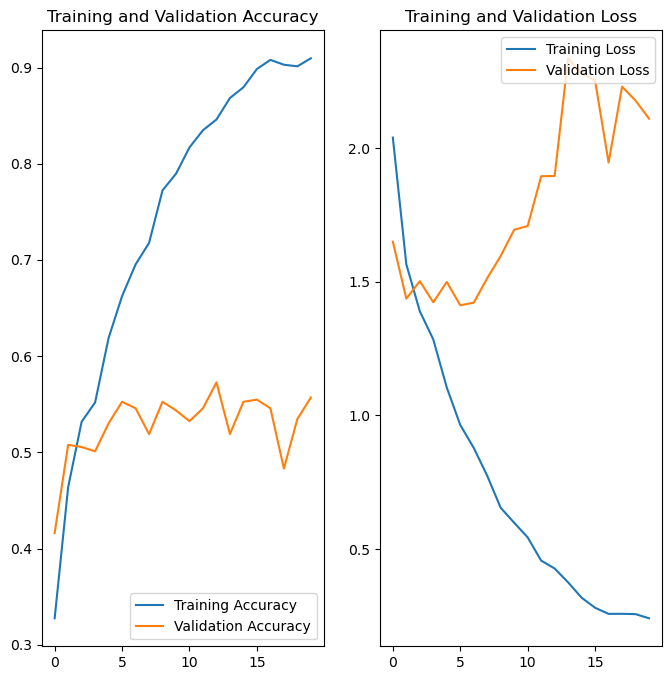

In [17]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Analysis
1. Training Accuracy and Loss Behavior
Training accuracy steadily improving: This indicates that the model is indeed learning and fitting the patterns in the training data. As the training progresses, the model becomes better at predicting the labels for the training samples, leading to a higher training accuracy.
Training loss continuously decreasing: The training loss measures how well the model fits the training data. A decreasing training loss shows that the model is reducing errors on the training set as it learns from more epochs.
2. Validation Accuracy and Loss Behavior
Validation accuracy peaks and then stagnates or decreases: The validation accuracy represents how well the model performs on unseen data. When validation accuracy stops improving and starts to decrease while training accuracy continues to rise, it suggests that the model is memorizing the training data rather than learning generalizable patterns. This is a classic sign of overfitting.
Validation loss increases over time: Ideally, the validation loss should decrease along with the training loss. When it starts to increase, it indicates that the model is making more mistakes on the validation set even though it performs better on the training set. This is another strong indicator of overfitting.
3. Understanding the Gap Between Training and Validation Performance
Widening gap between training and validation accuracy/loss: When the training accuracy remains high while validation accuracy lags behind, it indicates that the model has learned the specifics of the training data too well, including noise and minor details, rather than learning general features that apply to unseen data.
Overfitting essentially means the model has become too complex for the amount of training data it has seen. It has "memorized" the training examples instead of generalizing to new data.
4. Causes of Overfitting
Insufficient training data: If the amount of training data is small compared to the complexity of the model, the model may easily memorize the training data without learning generalized patterns.
Model complexity: Deep models with many parameters can easily fit the training data, but this also makes them prone to overfitting.
Lack of regularization: Regularization techniques like dropout, weight decay, or data augmentation are essential for preventing overfitting.
5. Mitigation Techniques for Overfitting
Regularization: Techniques such as L2 regularization (weight decay), dropout, and batch normalization can help prevent the model from overfitting.
Data Augmentation: Applying random transformations to the training data (like flipping, rotating, or scaling images) helps the model learn more generalized patterns.
Reduce Model Complexity: Use a simpler architecture (fewer layers or fewer units per layer).
Early Stopping: Stop training when the validation accuracy stops improving, rather than training for a fixed number of epochs.

In [18]:

#after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical", seed=123 ),
  layers.RandomRotation(0.1, seed=123),
  layers.RandomZoom(0.1, seed=123),
] , name="Data_Augmentation_Layer")

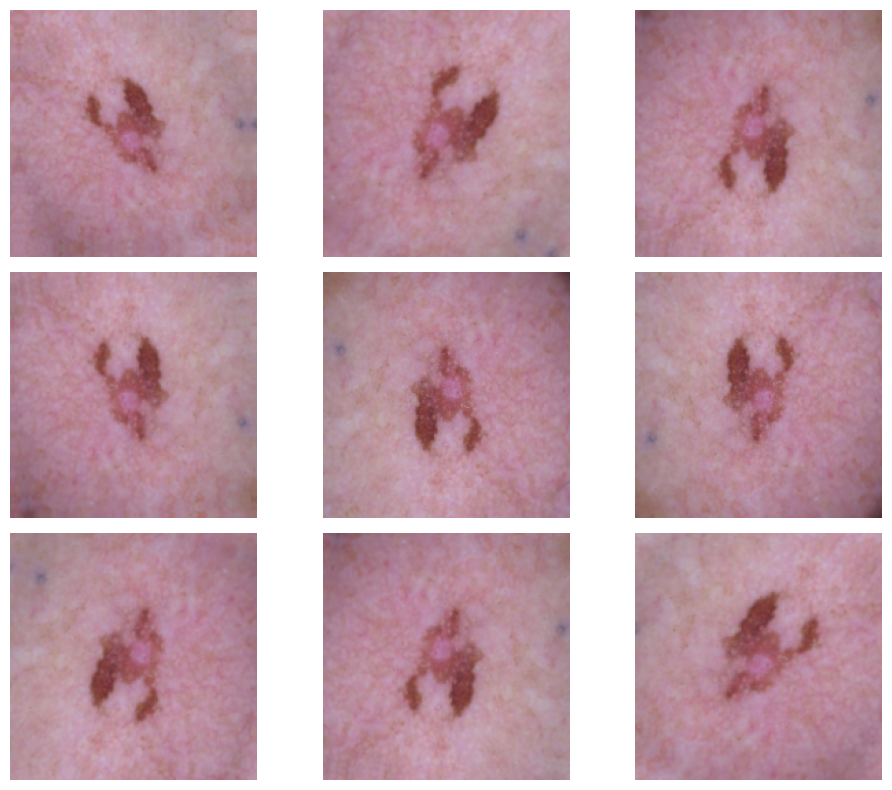

In [19]:

# Todo, visualize how your augmentation strategy works for one instance of training image.
random_num=random.randint(1,11)
# Your code goes here
plt.figure(figsize=(10, 8))
for images, _ in train_ds.skip(random_num-1).take(random_num):
  for i in range(9):
    augmented_images = data_augmentation(images) # data augmenatation
    ax = plt.subplot(3, 3, i + 1) # Create a 3x3 grid for the images
    plt.imshow(augmented_images[random_num].numpy().astype("uint8")) # Display the image
    plt.axis("off") # Turn off the axis
# Show the plot with all images
plt.tight_layout()
plt.show()

In [21]:

## You can use Dropout layer if there is an evidence of overfitting in your findings

model=Sequential(name="Melanoma_Detection_Model")
# Adding Rescaling layer
model.add(layers.Rescaling(1.0/255.0 , offset=0.0 , input_shape=(img_height,img_width,3), name="Rescaling_Layer"))
# Adding Data Augmentation
model.add( data_augmentation )
# First Part
model.add(layers.Conv2D(filters=16,kernel_size=(3,3),padding="same",activation="relu",  name="Conv2D_Layer_1"))  # adding first Convolution layer
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1")) # adding first Max Pooling layer
model.add(layers.Dropout(0.20 ,name="Dropout_1") )# adding dropouts
# second Part
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu",  name="Conv2D_Layer_2"))  # adding second Convolution layer
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2")) # adding second Max Pooling layer
model.add(layers.Dropout(0.20 ,name="Dropout_2") )# adding dropouts
# thrid Part
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_3")) # adding third Convolution layer
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_3")) # adding third Max Pooling layer
model.add(layers.Dropout(0.20 ,name="Dropout_3") )# adding dropouts
# Flattening the output
model.add(layers.Flatten(name="Flatten_Layer"))
# Fully Connected Layer
model.add(layers.Dense(units=128,activation="relu",name="FC_Layer_1") )# adding first fully connected layer
model.add(layers.Dropout(0.20,name="Dropout_4")) # adding dropouts
# Output Layer
model.add(layers.Dense(units=len(class_names),activation="softmax",name="Output_Layer")) # adding output layer

# Compiling the model

In [22]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:

# View the summary of all layers
model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Data_Augmentation_Layer         │ (None, 180, 180, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_Layer_1 (Conv2D)         │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_Layer_1            │ (None, 90, 90, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_Layer_2 (Conv2D)         │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_Layer_2            │ (None, 45, 45, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_Layer_3 (Conv2D)         │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_Layer_3            │ (None, 22, 22, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_3 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC_Layer_1 (Dense)              │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

# Training the model

In [24]:

## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    verbose=1)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.1938 - loss: 2.4893 - val_accuracy: 0.3020 - val_loss: 1.9599
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.3135 - loss: 1.8747 - val_accuracy: 0.3289 - val_loss: 1.9029
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.3877 - loss: 1.7260 - val_accuracy: 0.3714 - val_loss: 1.7246
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.3970 - loss: 1.6292 - val_accuracy: 0.3468 - val_loss: 1.8025
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.4266 - loss: 1.6456 - val_accuracy: 0.4899 - val_loss: 1.5787
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.4480 - loss: 1.5524 - val_accuracy: 0.3893 - val_loss: 1.7471
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.4558 - loss: 1.5753 - val_accuracy: 0.4989 - val_loss: 1.4927
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.4852 - loss: 1.4728 - val_accuracy: 0.4966 - v

# Visualizing the results

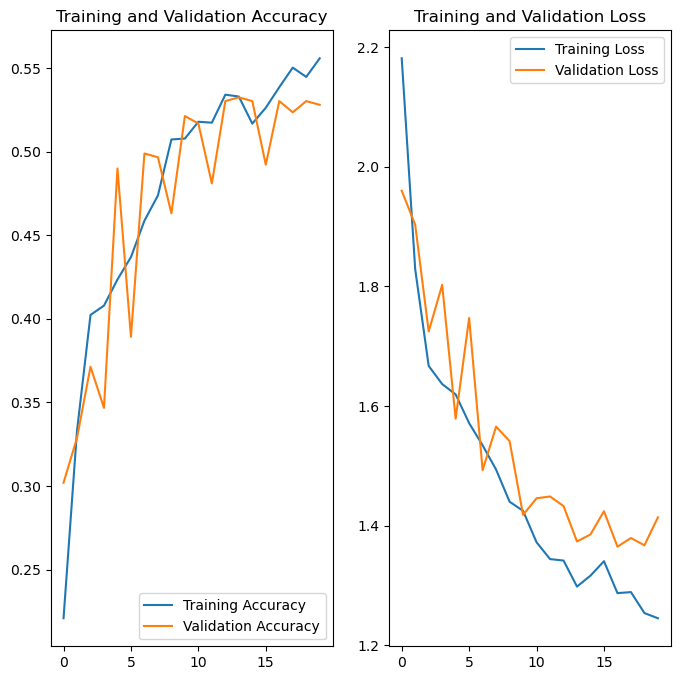

In [25]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:

list_images = []
for i in class_names:
    list_images.append(len(list(data_dir_train.glob(i+'/*.jpg'))))

data = {'Class Names': class_names, 'Image Count': list_images}
original_df = pd.DataFrame(data)

In [27]:

original_df.head(9)

Class Names  Image Count
0           actinic keratosis          114
1        basal cell carcinoma          376
2              dermatofibroma           95
3                    melanoma          438
4                       nevus          357
5  pigmented benign keratosis          462
6        seborrheic keratosis           77
7     squamous cell carcinoma          181
8             vascular lesion          139

Which class has the least number of samples?

Answer - seborrheic keratosis has the least number of samples - 77

Which classes dominate the data in terms proportionate number of samples?
Answer - pigmented benign keratosis dominates the data in terms proportionate number of samples - 462

Rectify the class imbalance

In [28]:
path_to_training_dataset="C:/Users/arpit/Desktop/test/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to C:/Users/arpit/Desktop/test/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B94625EAD0>: 100%|██████████| 500/500 [00:00<00:00, 533.78 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to C:/Users/arpit/Desktop/test/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B949C359D0>: 100%|██████████| 500/500 [00:00<00:00, 539.97 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to C:/Users/arpit/Desktop/test/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B8FC221E50>: 100%|██████████| 500/500 [00:00<00:00, 579.11 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to C:/Users/arpit/Desktop/test/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x1B949BB6E50>: 100%|██████████| 500/500 [00:03<00:00, 134.51 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to C:/Users/arpit/Desktop/test/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x1B949BC9790>: 100%|██████████| 500/500 [00:03<00:00, 136.77 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to C:/Users/arpit/Desktop/test/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1B949BD7D10>: 100%|██████████| 500/500 [00:00<00:00, 559.90 Samples/s]


Initialised with 77 image(s) found.
Output directory set to C:/Users/arpit/Desktop/test/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1B8FC2054D0>: 100%|██████████| 500/500 [00:01<00:00, 276.47 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to C:/Users/arpit/Desktop/test/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1B949BEC990>: 100%|██████████| 500/500 [00:00<00:00, 595.81 Samples/s]


Initialised with 139 image(s) found.
Output directory set to C:/Users/arpit/Desktop/test/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B949C70F90>: 100%|██████████| 500/500 [00:00<00:00, 565.01 Samples/s]                  


In [29]:

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [30]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['C:\\Users\\arpit\\Desktop\\test\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7dbf73e5-14b6-498d-baa4-7d6b49f9a88b.jpg',
 'C:\\Users\\arpit\\Desktop\\test\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_83f2b4a2-3845-4738-a074-dac6e8f447c6.jpg',
 'C:\\Users\\arpit\\Desktop\\test\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_cd8a72e5-4029-4c98-926c-d2291618dabd.jpg',
 'C:\\Users\\arpit\\Desktop\\test\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_37ad7f04-22f7-470c-9387-e89871c46266.jpg',
 'C:\\Users\\arpit\\Desktop\\test\\CNN_assignment\\Skin canc

In [31]:

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [32]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df,df2],ignore_index=True)

In [34]:
new_df['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

 Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

In [36]:
# Create a training dataset
data_dir_train="C:/Users/arpit/Desktop/EPG/melanoma/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)
     

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [37]:
# Create a validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [39]:
# Create your model (make sure to include normalization)
## your code goes here
model=Sequential(name="Melanoma_Detection_Model")
# Adding Rescaling layer
model.add(layers.Rescaling(1.0/255.0 , offset=0.0 , input_shape=(img_height,img_width,3), name="Rescaling_Layer"))
# Adding Data Augmentation
model.add( data_augmentation )
# First Part
model.add(layers.Conv2D(filters=16,kernel_size=(3,3),padding="same",activation="relu",  name="Conv2D_Layer_1"))  # adding first Convolution layer
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1")) # adding first Max Pooling layer
model.add(layers.Dropout(0.20 ,name="Dropout_1") )# adding dropouts
# Second Part
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu",  name="Conv2D_Layer_2"))  # adding second Convolution layer
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2")) # adding first Max Pooling layer
model.add(layers.Dropout(0.20 ,name="Dropout_2") )# adding dropouts
# third Part
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_3")) # adding third Convolution layer
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_3")) # adding second Max Pooling layer
model.add(layers.Dropout(0.20 ,name="Dropout_3") )# adding dropouts
# Flattening the output
model.add(layers.Flatten(name="Flatten_Layer"))
# Fully Connected Layer
model.add(layers.Dense(units=128,activation="relu",name="FC_Layer_1") )# adding first fully connected layer
model.add(layers.Dropout(0.20,name="Dropout_4")) # adding dropouts
# Output Layer
model.add(layers.Dense(units=len(class_names),activation="softmax",name="Output_Layer")) # adding output layer

In [40]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [41]:

# View the summary of all layers
model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Data_Augmentation_Layer         │ (None, 180, 180, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_Layer_1 (Conv2D)         │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_Layer_1            │ (None, 90, 90, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_Layer_2 (Conv2D)         │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_Layer_2            │ (None, 45, 45, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_Layer_3 (Conv2D)         │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_Layer_3            │ (None, 22, 22, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_3 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC_Layer_1 (Dense)              │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
#  Train your model
epochs = 30
steps_per_epoch = len(train_ds) // batch_size
validation_steps = len(val_ds) // batch_size
## Your code goes here, use 30 epochs.
history = model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    verbose=1)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.1480 - loss: 2.2708 - val_accuracy: 0.3044 - val_loss: 1.8224
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.3400 - loss: 1.7204 - val_accuracy: 0.4180 - val_loss: 1.5614
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.4332 - loss: 1.4940 - val_accuracy: 0.4640 - val_loss: 1.4209
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.4705 - loss: 1.3932 - val_accuracy: 0.4900 - val_loss: 1.3615
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.4804 - loss: 1.3599 - val_accuracy: 0.4603 - val_loss: 1.3471
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.4906 - loss: 1.3283 - val_accuracy: 0.4855 - val_loss: 1.3801
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.5103 - loss: 1.2605 - val_accuracy: 0.5219 - val_loss: 1.2346
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.5196 - loss: 1.2408 - 

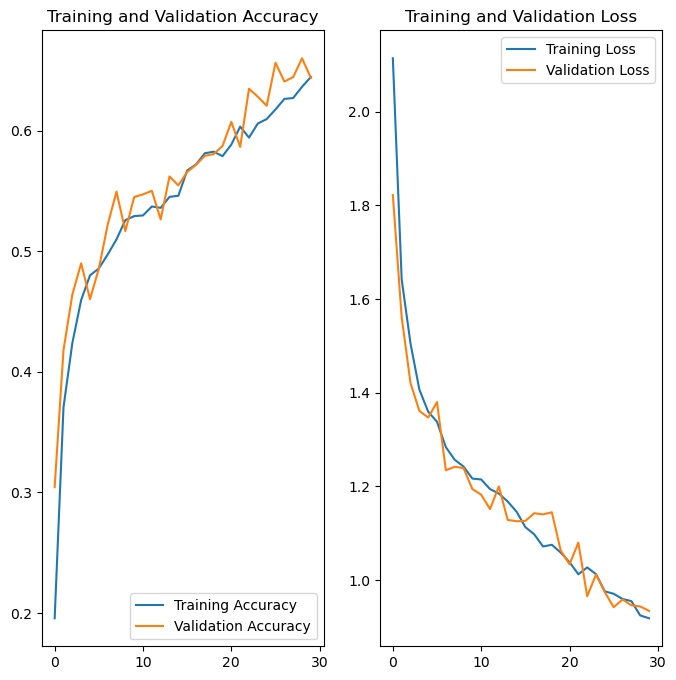

In [43]:
# Visualize the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Because to augmentation and class imbalance management, training and validation accuracy has enhanced dramatically. The model does not overfit. This model can serve as the final model.
Model Learning Effectively: The model is making steady progress without significant signs of overfitting. The alignment between training and validation metrics suggests good generalization.
The validation loss shows some small fluctuations, but overall, it follows a downward trend, similar to the training loss. This is a positive sign, suggesting that the model is generalizing well.
Both training and validation loss decrease consistently across epochs, indicating that the model is learning to minimize the error in predictions.